# Experiments on the grid map

In [1]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

import sys
sys.path.append('../')

from MAPF import SpaceTimeAStar, MultiAgentAStar, CBS, PBS
from MAPF.HighLevelSearch import SearchNodeContainer

%load_ext autoreload
%autoreload 2

%matplotlib inline


In [2]:

def BackwardInvariantCBS(G, start_nodes,goal_nodes, edge_weights = None, \
                         max_iter = 2000, metric = 'flowtime',\
                         check_edge_conflicts = False, search_type = 'best_first'):


    if metric == 'flowtime':
        metric = flowtime
    elif metric == 'makespan':
        metric = makespan
    else:
        print('Metric {} is not supported. Please input "flowtime" or "makespan".'.format(metric))

    if edge_weights is None:
        edge_weights = {e:1 for e in G.edges} # Assume uniform weights if None is given.
        edge_weights.update({e[::-1]:1 for e in G.edges})

    nx.set_edge_attributes(G,edge_weights,'weight')

    hScore = dict(nx.shortest_path_length(G,weight = 'weight')) # The heuristic score used in SpaceTimeAStar

    # Initialization: 
    # Plan inidivual paths for agent agent without considering conflicts.
    # We simply call the standard networkx library.
    p = nx.shortest_path(G,weight = 'weight') # The [weight] argument here should be the key to weight values in the edge data dictionary.
    plan0 = [p[s][g] for s, g in zip(start_nodes, goal_nodes)]

    CT = ConstraintTree()
    ROOT = CT.add_node(None,plan0,metric(G,plan0,goal_nodes),[]) # Adding the root node. 

    OPEN = SearchNodeContainer()
    OPEN.push(CT.get_cost(ROOT),ROOT) 

    count = 0
    while not OPEN.empty() and count<=max_iter:
        count+=1 
        # CBS does not have a way to determine infeasibility. 
        # To avoid infinite loops, we stop it when it exceeded an iteration threshold..
        cost, parent_node = OPEN.pop()
        solution = CT.get_solution(parent_node)

        # Look for the first conflict.
        conflict = find_conflict(solution,check_edge_conflicts)

        # print(OPEN.queue, conflict,solution)
        if not conflict:
            # print('Solution found', solution, cost)
            # break
            
            print('Total iterations = ',count,'OPEN empty?',OPEN.empty()) 
            return solution, cost
        else:

            a1, a2, c, t = conflict # c could either be a node or an edge.
            print('conflict',conflict,'t',t)

            if type(c) is int:
                t0 = t-1
            elif type(c) is tuple:
                t0 = t

            for a in (a1,a2): # Create two children of the current CT node.
               
                # Construct the constraint set
                other_agent_pos = set()
                other_traversed_edges = set()
                for i in range(len(solution)):
                    if i!=a:
                        next_t = min(t0+1,len(solution[i])-1)
                        other_agent_pos.add(solution[i][next_t])
                        other_traversed_edges.add(tuple(solution[i][next_t-1:next_t+1]))

                # print('other agent pos',other_agent_pos)
                # Construct the constraint set for the agent.
                node_constraints = {s:set() for s in G}            
                for s in other_agent_pos:
                    node_constraints[s].add(1)

                edge_constraints = {e:set() for e in G.edges}
                edge_constraints.update({e[::-1]:set() for e in G.edges})

                for e in other_traversed_edges: 
                    if len(e)>1:# Ignore the traverses which stay at the same node.
                        edge_constraints[e].add(0)

                if type(c) is int:
                    node_constraints[c].add(1)
                elif type(c) is tuple:
                    edge_constraints[c].add(0)
                    edge_constraints[c[::-1]].add(0)


                # print('agent',a,'node constraints',node_constraints,'c',c)
                # print('solution[a]', solution[a],'t0',t0)
                # Call Space-time A* algorithm to partially replan the agent's path.
                curr_t = min(t0,len(solution[a])-1)
                result = SpaceTimeAStar(G, start=solution[a][curr_t], goal=goal_nodes[a]\
                                        ,node_constraints=node_constraints,edge_constraints=edge_constraints\
                                        , hScore = hScore)

                if result: # If there is a feasible single-agent path. 
                    # print('result',result,'start',solution[a][t-1],'goal',goal_nodes[a],'solution',solution)
                    path, gscore = result
                    new_solution = deepcopy(solution)
                    new_solution[a] = solution[a][:curr_t] + path
                    # if count>=0.98*max_iter:
                    # print('agent',a,'old_solution',solution,'new_solution',new_solution)
                    # print('old_solution[a]',solution[a],'new_solution[a]',new_solution[a],'path',path)
                    # print('old_solution[:t]',solution[a][:curr_t])
                    

                    # Create a new child in the Constraint Tree.
                    new_node_ID = CT.add_node(parent_node, new_solution,\
                                                 metric(G,new_solution,goal_nodes),[])

                    # Push the new child onto the OPEN queue.
                    OPEN.push(CT.get_cost(new_node_ID),new_node_ID)
                # else:
                #     print('No SAPF solution')

    print('Total iterations = ',count,'OPEN empty?',OPEN.empty()) 
    return None


In [3]:
def prune_obstacles_from_G(G, obstacle_ratio, max_iter=100):
    '''
        Putting blocked nodes on the graph G can be viewed equivalently as removing those
        blocked nodes, along with their connections to other nodes, from the graph.
    '''
    G_pruned = deepcopy(G)

    for _ in range(max_iter):
        obstacle_num = int(obstacle_ratio * G.number_of_nodes())
        obstacles = np.random.choice(range(n_nodes),size = obstacle_num, replace = False)

        for obs in obstacles:
            G_pruned.remove_node(obs)

        if nx.is_connected(G_pruned):
            return G_pruned, obstacles 
    return None

In [4]:
n_nodes = 400
# n_nodes = 16
obstacle_ratio = 0.1


ldim = int(np.ceil(np.sqrt(n_nodes)))
udim = int(np.floor(np.sqrt(n_nodes)))

G = nx.grid_graph([ldim,udim])
G = nx.convert_node_labels_to_integers(G)
for i in G: # Add self-loops to allow the agent staying at the node.
    G.add_edge(i,i)


In [5]:
G_pruned, obs = prune_obstacles_from_G(G,obstacle_ratio)

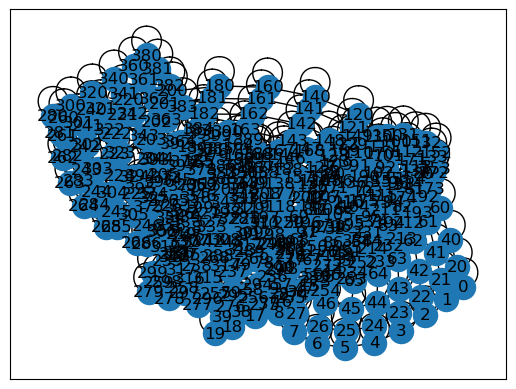

In [6]:
nx.draw_networkx(G)

In [7]:
from tqdm import trange
from functools import partial
from time import time
from MAPF.metrics import flowtime

In [8]:
def benchmark(G, start_nodes, goal_nodes):
    p = nx.shortest_path(G)
    plan = [p[s][g] for s, g in zip(start_nodes, goal_nodes)]
    return plan,flowtime(G,plan,goal_nodes)

In [11]:
n_agents = 50
n_expr = 50
np.random.seed(32429)


# print(start_nodes,goal_nodes)
labeled_goals = True 

messages = ['CBS','CBS: depth first','Backward Invariant CBS', 'PBS: Depth First', 'PBS: Best First','Benchmark: unconstrained']
algs = [
    partial(CBS,max_iter=2000,check_edge_conflicts=True,search_type='best_first'),
    partial(CBS,max_iter=2000,check_edge_conflicts=True,search_type='depth_first'),
        partial(BackwardInvariantCBS,max_iter=200,check_edge_conflicts=True),
        partial(PBS,search_type = 'depth_first'),
        partial(PBS,search_type = 'best_first'),
    benchmark
       ]
results = {msg:{'time':[],'cost':[]} for msg in messages}

to_test = [1,3,5]

for _ in range(n_expr):
    start_nodes = tuple(np.random.choice(range(n_nodes),n_agents,replace=False)) # Must be hashable.
    goal_nodes = tuple(np.random.choice(range(n_nodes),n_agents,replace=False)) 
    
    for i in to_test:
        t = time()
        output =algs[i](G,start_nodes,goal_nodes) 
        
        if output is not None:
            plan, cost = output
            elapse = time()-t
        else:
            cost = np.inf
            elapse = np.inf
        
        results[messages[i]]['cost'].append(cost)
        results[messages[i]]['time'].append(elapse)

        print(messages[i], 'cost',cost,'time',time()-t)
        
        

CBS: depth first cost 609 time 1.255866289138794
PBS: Depth First cost 622 time 2.3101439476013184
Benchmark: unconstrained cost 601 time 0.1703181266784668
CBS: depth first cost 622 time 2.1665639877319336
PBS: Depth First cost 618 time 1.661823034286499
Benchmark: unconstrained cost 608 time 0.16797709465026855
CBS: depth first cost 699 time 4.181241750717163
PBS: Depth First cost 704 time 3.987755060195923
Benchmark: unconstrained cost 675 time 0.133195161819458
CBS: depth first cost 722 time 2.9039158821105957
PBS: Depth First cost 718 time 3.5582149028778076
Benchmark: unconstrained cost 701 time 0.13306117057800293
CBS: depth first cost 732 time 2.8174400329589844
PBS: Depth First cost 734 time 3.202023983001709
Benchmark: unconstrained cost 722 time 0.17305970191955566
CBS: depth first cost 636 time 1.451092004776001
PBS: Depth First cost 638 time 1.9765448570251465
Benchmark: unconstrained cost 622 time 0.13504791259765625
CBS: depth first cost 724 time 1.8395841121673584
PBS: 

KeyboardInterrupt: 

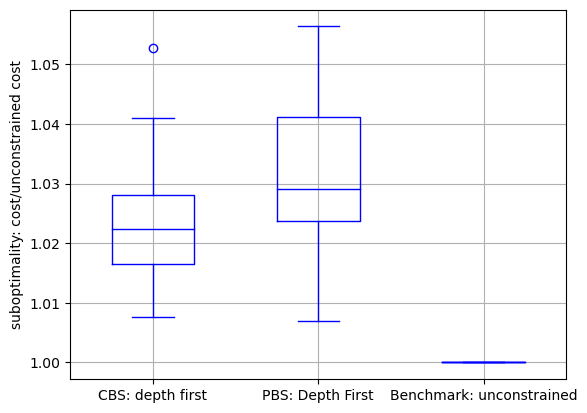

In [12]:
labels = [messages[i] for i in to_test]
x = np.arange(len(to_test))  # the label locations
width = 0.5
c = 'blue'
benchmark_cost = np.array(results['Benchmark: unconstrained']['cost'])
plt.boxplot( [np.array(results[msg]['cost'])/benchmark_cost for msg in labels], \
            positions = x, widths= width,\
             boxprops=dict(color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c)
           )
plt.xticks(x,labels)
plt.ylabel('suboptimality: cost/unconstrained cost')
plt.grid(True)
plt.show()

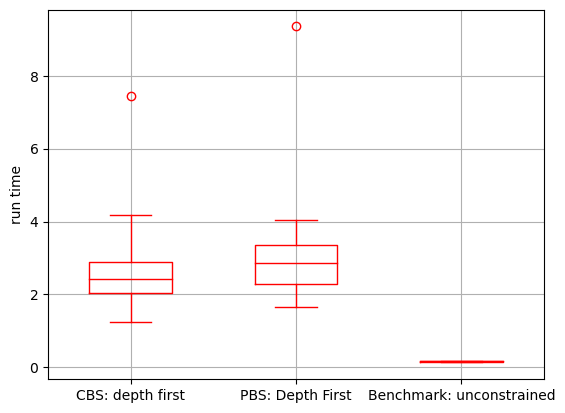

In [13]:
labels = [messages[i] for i in to_test]
x = np.arange(len(to_test))  # the label locations
width = 0.5
c = 'red'
plt.boxplot( [results[msg]['time'] for msg in labels], \
            positions = x, widths= width,\
             boxprops=dict(color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c)
           )
plt.xticks(x,labels)
plt.ylabel('run time')
plt.grid(True)
plt.show()